In [2]:
import multiprocessing
multiprocessing.set_start_method("fork")

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
%matplotlib inline

from prophet import Prophet

In [3]:
%load_ext autoreload
%autoreload 1

In [5]:
%aimport prophet_projpred
%aimport prophet_projpred.models
%aimport prophet_projpred.family
%aimport prophet_projpred.stats

In [6]:
df = pd.read_csv('data/ecuador_dataset.csv')
df['date']=pd.to_datetime(df['date'])
df = df.loc[
    df['family'].isin(
        ['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DELI', 'GROCERY I', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PRODUCE']),
    ['family', 'date', 'unit_sales', 'onpromotion', 'oil_price', 'precipitation', 
     'tavg', 'tmax', 'tmin', 'yellow maize', 'potatoes']
]
df = df.groupby(by='date').agg(
    unit_sales = pd.NamedAgg(column='unit_sales', aggfunc='sum'),
    onpromotion = pd.NamedAgg(column='onpromotion', aggfunc='sum'),
    oil_price = pd.NamedAgg(column='oil_price', aggfunc='first'),
    precipitation = pd.NamedAgg(column='precipitation', aggfunc='first'),
    tmax = pd.NamedAgg(column='tmax', aggfunc='first'),
    tmin = pd.NamedAgg(column='tmin', aggfunc='first'),
    tavg = pd.NamedAgg(column='tavg', aggfunc='first'),
    yellow_maize = pd.NamedAgg(column='yellow maize', aggfunc='first'),
    potatoes = pd.NamedAgg(column='potatoes', aggfunc='first')
)
df = df.rename(columns={'unit_sales': 'y'})
df = df.rename_axis('ds')
df[['y', 'onpromotion']] = np.log(df[['y', 'onpromotion']])

train = df.loc['2015-05-01':'2017-04-30',:].reset_index()
future = df.loc['2015-05-01':'2017-06-30',:].reset_index()

future

,ds,y,onpromotion,oil_price,precipitation,tmax,tmin,tavg,yellow_maize,potatoes
0,2015-05-01,12.508238,7.664816,59.10,0.0,20.300000,4.066667,13.950000,21.766667,0.295333
1,2015-05-02,12.606216,6.190315,59.10,0.0,21.000000,3.700000,13.400000,21.783333,0.295667
2,2015-05-03,12.677281,6.180017,59.10,20.1,21.000000,6.000000,11.300000,21.800000,0.296000
3,2015-05-04,12.323003,6.068426,58.92,16.0,19.000000,5.300000,12.100000,21.816667,0.296333
4,2015-05-05,12.197967,6.059123,60.38,8.9,20.100000,6.800000,11.900000,21.833333,0.296667
...,...,...,...,...,...,...,...,...,...,...
783,2017-06-26,12.583300,7.859027,43.24,0.0,18.520000,7.000000,12.920000,17.961667,0.274667
784,2017-06-27,12.430620,8.023880,44.25,0.0,18.466667,7.066667,12.933333,17.990000,0.276000
785,2017-06-28,12.574611,8.740177,44.74,0.0,18.413333,7.133333,12.946667,18.018333,0.277333
786,2017-06-29,12.367607,8.013674,44.88,0.0,18.360000,7.200000,12.960000,18.046667,0.278667


In [7]:
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])
holidays = holidays[holidays['locale_name'].isin(['Quito', 'Ecuador'])]
holidays = holidays.sort_values(by=['description', 'date']).reset_index()
holidays = holidays[['date', 'description']].rename(columns={'date': 'ds', 'description': 'holiday'})
holidays

,ds,holiday
0,2013-05-24,Batalla de Pichincha
1,2014-05-24,Batalla de Pichincha
2,2015-05-24,Batalla de Pichincha
3,2016-05-24,Batalla de Pichincha
4,2017-05-24,Batalla de Pichincha
...,...,...
182,2013-04-29,Viernes Santo
183,2014-04-18,Viernes Santo
184,2015-04-03,Viernes Santo
185,2016-03-25,Viernes Santo


In [8]:
m = prophet_projpred.ReferenceModel(changepoint_prior_scale=0.01, holidays=holidays, mcmc_samples=400, uncertainty_samples=800)

In [9]:
m.add_seasonality(name='yearly', period=365.25, fourier_order=8, prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=8, prior_scale=10)
m.add_seasonality(name='weekly', period=7, fourier_order=5, prior_scale=10)
m.add_regressor('onpromotion')
m.add_regressor('oil_price')
m.add_regressor('precipitation')
m.add_regressor('tavg')
m.add_regressor('tmax')
m.add_regressor('tmin')
m.add_regressor('potatoes')
m.add_regressor('yellow_maize')

In [12]:
m.fit(train)
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

Exception: Prophet object can only be fit once. Instantiate a new object.

In [17]:
import os
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [63]:
with suppress_stdout_stderr():
    path = m.search(train, future)

        variable        kl
0   yellow_maize  0.161182
1           tavg  0.764633
2       potatoes  0.966613
3      oil_price  1.013713
4           tmin  1.383948
5  precipitation  1.407106
6           tmax  1.415540
7    onpromotion  1.731620
        variable        kl
0      oil_price  0.111929
1           tavg  0.125053
2  precipitation  0.150325
3           tmax  0.155045
4           tmin  0.158770
5    onpromotion  0.165564
6       potatoes  0.171563
        variable        kl
0           tavg  0.092041
1           tmax  0.101794
2  precipitation  0.104591
3           tmin  0.107339
4       potatoes  0.112828
5    onpromotion  0.121312
        variable        kl
0  precipitation  0.036915
1    onpromotion  0.052139
2           tmax  0.084101
3           tmin  0.088200
4       potatoes  0.090961
      variable        kl
0  onpromotion  0.006934
1         tmin  0.031815
2         tmax  0.036853
3     potatoes  0.038755
   variable        kl
0      tmax  0.002524
1  potatoes  0.006260

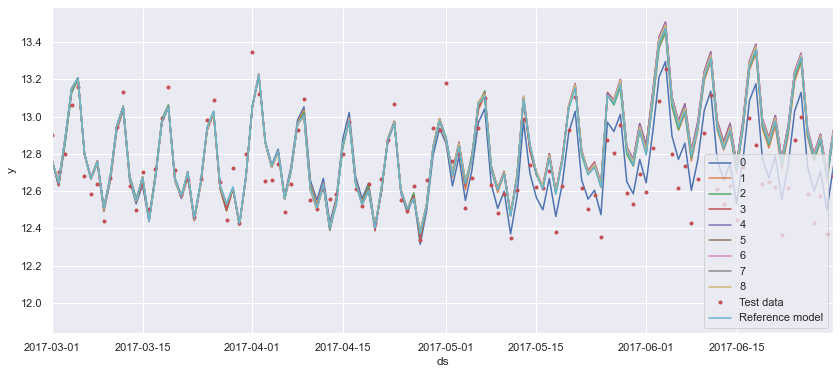

In [91]:
with suppress_stdout_stderr():
    stat_table = m.generate_submodels(path, train, future, ndraws_pred=20, iter=3*1e4)

In [93]:
stat_table

,elpd,mape,kl
0,-32.262903,0.007563,39.590131
1,-2060.111620,0.016538,5.930744
2,-2013.597176,0.017131,4.374809
3,-3011.607045,0.019008,2.847607
4,-2356.804794,0.018881,1.523970
5,-1887.475910,0.018069,0.708626
6,-2300.572537,0.018552,0.426915
7,-2052.523515,0.018002,0.303287
8,-2183.949983,0.018237,0.125003


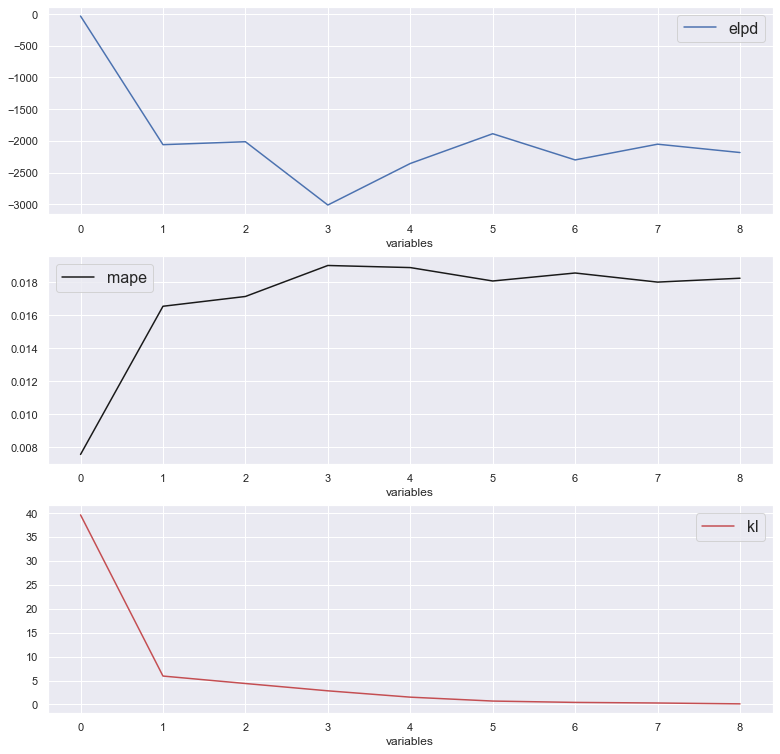

In [92]:
fig, ax = plt.subplots(3,1, figsize=(13,13))
ax[0].plot(stat_table['elpd'], label="elpd")
ax[1].plot(stat_table['mape'], label="mape", c='k')
ax[2].plot(stat_table['kl'], label="kl", c='r')
for axis in ax:
    axis.legend(prop={'size': 16})
    axis.set_xlabel('variables')
plt.show()
